## Gathering Data and Imports

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/walmart-sales-forecast/features.csv
/kaggle/input/walmart-sales-forecast/stores.csv
/kaggle/input/walmart-sales-forecast/train.csv
/kaggle/input/walmart-sales-forecast/test.csv


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Installing Spark and Creating Spark session

In [ ]:
# Installing pyspark
!pip install pyspark
import pyspark.sql.functions as f
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Time Series analysis').getOrCreate()

### Loading the Train.csv Dataset into a spark DataFrame

In [29]:
df = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/walmart-sales-forecast/train.csv')
df.limit(5).toPandas().style.hide(axis="index")

Store,Dept,Date,Weekly_Sales,IsHoliday
1,1,2010-02-05,24924.500000,False
1,1,2010-02-12,46039.490000,True
1,1,2010-02-19,41595.550000,False
1,1,2010-02-26,19403.540000,False
1,1,2010-03-05,21827.900000,False


In [27]:
mn_dt = df.select('Date').agg(f.min('Date')).collect()[0][0]
mx_dt = df.select('Date').agg(f.max('Date')).collect()[0][0]
print('Total Rows: ',df.count())
print('Min Date: ', mn_dt)
print('Max Date: ', mx_dt)

Total Rows:  421570
Min Date:  2010-02-05
Max Date:  2012-10-26


#### Loading Stores.csv into a dataframe

In [28]:
stores = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/walmart-sales-forecast/stores.csv')
stores.limit(5).toPandas().style.hide(axis="index")

Store,Type,Size
1,A,151315
2,A,202307
3,B,37392
4,A,205863
5,B,34875


In [7]:
print('Total Rows: ', stores.count())
print('Total Stores: ', stores.select('Store').distinct().count())
stores.select('Type').distinct().show()

Total Rows:  45
Total Stores:  45
+----+
|Type|
+----+
|   B|
|   C|
|   A|
+----+



#### Loading features.csv into a dataframe

In [30]:
features = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/walmart-sales-forecast/features.csv')
features.limit(5).toPandas().style.hide(axis="index")

Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
1,2010-02-05,42.310000,2.572000,NA,NA,NA,NA,NA,211.0963582,8.106,False
1,2010-02-12,38.510000,2.548000,NA,NA,NA,NA,NA,211.2421698,8.106,True
1,2010-02-19,39.930000,2.514000,NA,NA,NA,NA,NA,211.2891429,8.106,False
1,2010-02-26,46.630000,2.561000,NA,NA,NA,NA,NA,211.3196429,8.106,False
1,2010-03-05,46.500000,2.625000,NA,NA,NA,NA,NA,211.3501429,8.106,False


In [54]:
mn_dt = features.select('Date').agg(f.min('Date')).collect()[0][0]
mx_dt = features.select('Date').agg(f.max('Date')).collect()[0][0]
print('Total Rows: ',features.count())
print('Min Date: ', mn_dt)
print('Max Date: ', mx_dt)

Total Rows:  8190
Min Date:  2010-02-05
Max Date:  2013-07-26


#### Joining entire dataset to make features

In [12]:
# Converting 'NA' strings in MarkDown columns to null values
for i in range(1,6):
    features = features.withColumn(
        f'MarkDown{i}', f.when(f.col(f'MarkDown{i}')=='NA', None).otherwise(
            f.col(f'MarkDown{i}')).cast('float'))

In [13]:
pdf = df.join(
    stores, on='Store', how='inner').join(
    features.drop('IsHoliday'), on=['Date','Store'], how='left').toPandas()
pdf['Date'] = pd.to_datetime(pdf['Date'])
pdf.set_index('Date', inplace=True)
pdf["CPI"] = pd.to_numeric(pdf["CPI"], downcast="float")
pdf["Unemployment"] = pd.to_numeric(pdf["Unemployment"], downcast="float")
pdf.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096359,8.106
2010-02-12,1,1,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242172,8.106
2010-02-19,1,1,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289139,8.106
2010-02-26,1,1,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319641,8.106
2010-03-05,1,1,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [14]:
pdf.dtypes

Store             int32
Dept              int32
Weekly_Sales    float64
IsHoliday          bool
Type             object
Size              int32
Temperature     float64
Fuel_Price      float64
MarkDown1       float32
MarkDown2       float32
MarkDown3       float32
MarkDown4       float32
MarkDown5       float32
CPI             float32
Unemployment    float32
dtype: object

## Visualizations

#### Stores Data

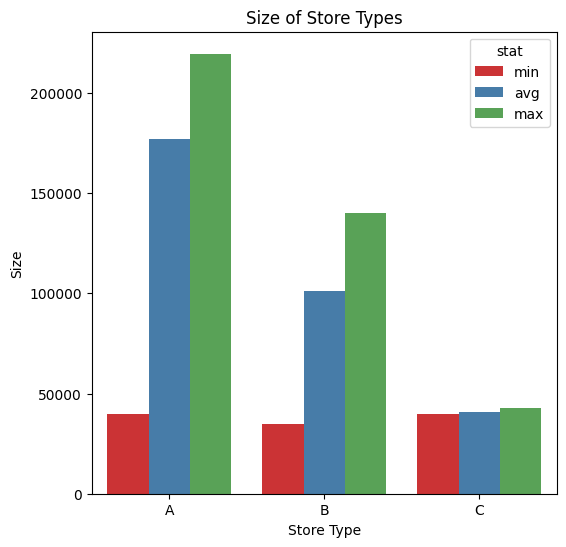

In [49]:
# Checking min, max, average of store by Type
stdf = stores.groupBy('Type').agg(
    f.min('Size').alias('min'), 
    f.round(f.avg('Size'),2).alias('avg'), 
    f.max('Size').alias('max')).orderBy('Type').toPandas()

m_df = pd.melt(stdf, id_vars="Type", var_name="stat", value_name="Size")
fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(x='Type', y='Size', hue='stat', data=m_df, ax=ax, palette='Set1').set_title('Size of Store Types')
plt.xlabel('Store Type')
plt.show()

#### Observations
- Type 'A' are the biggest store types with highest 'max' and 'average'  
- Type 'C' are the smallest stores with lowest 'max' and 'average'    
- Type 'B' average store size is in the middle  
- But the Minimun store size is close for all the store types  

#### Sales Data

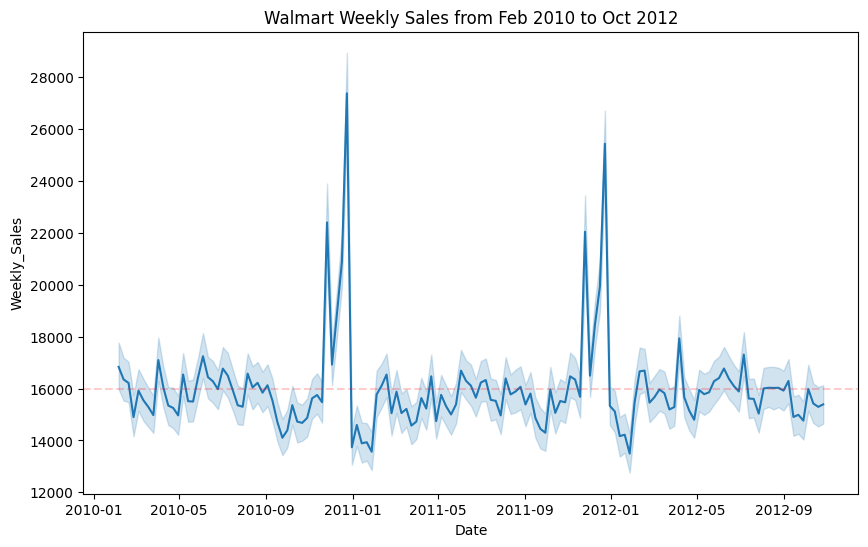

In [28]:
plt.figure(figsize=(10,6))
sns.lineplot(data=pdf, 
             x='Date', 
             y='Weekly_Sales',
            ).set_title('Walmart Weekly Sales from Feb 2010 to Oct 2012')
plt.axhline(pdf['Weekly_Sales'].mean(), color='r', alpha=0.2, linestyle='--')
plt.show()

#### Observations
- We see a spike in Sales during the holiday season (November to December) every year  
- The spike was highest on 2011  
- Average sales moves around 16000$ for the rest of the Months  

#### Taking a closer look at the Spike

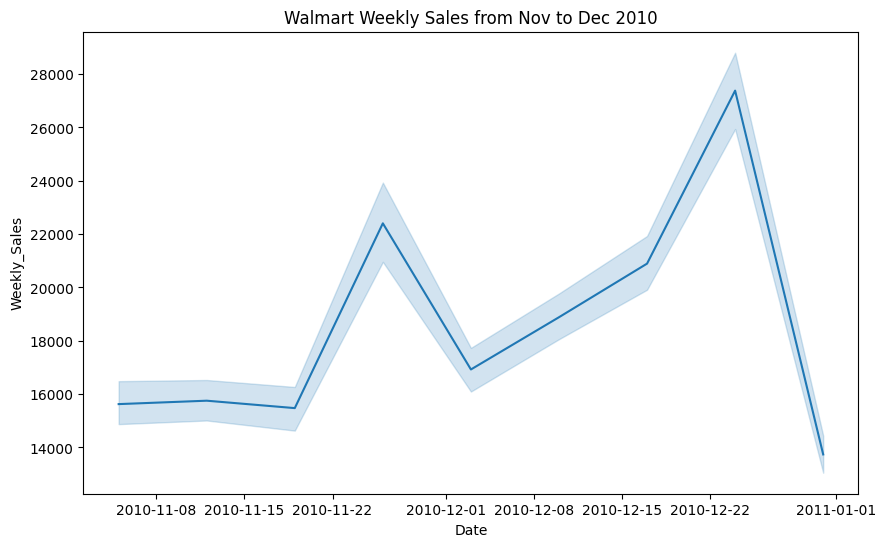

In [35]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=pdf.loc[(pdf.index >'2010-11-01') & (pdf.index<'2011-01-01')], 
    x='Date', y='Weekly_Sales'
    ).set_title('Walmart Weekly Sales from Nov to Dec 2010')
plt.show()

**The spike is seen during ThanksGiving (23-Nov) Black Friday(24-Nov) and Christmas (25-Dec)**

## Analyzing Sales by Month, Quarter, Year

In [15]:
pdf['Day'] = pdf.index.day
pdf['Month'] = pdf.index.month
pdf['Quarter'] = pdf.index.quarter
pdf['Year'] = pdf.index.year

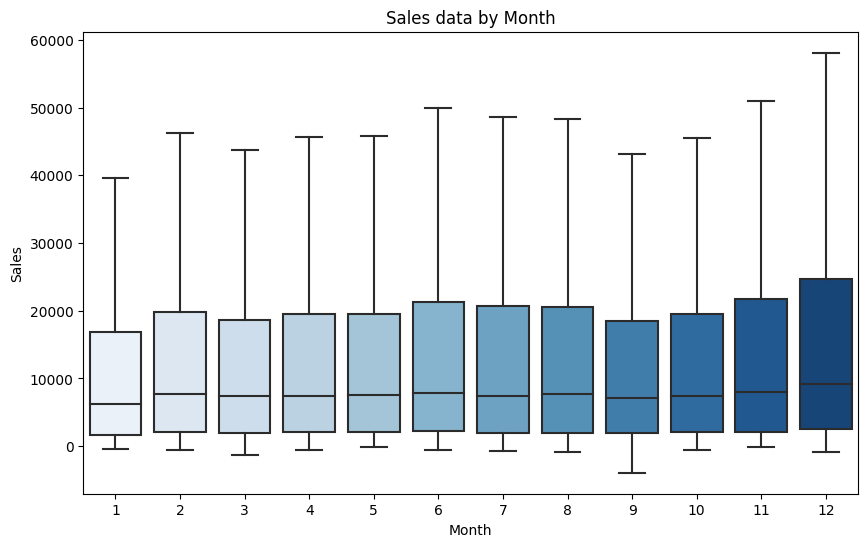

In [70]:
plt.figure(figsize=(10,6))
sns.boxplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')], x='Month', y='Weekly_Sales', 
            palette='Blues', showfliers=False
           ).set_title('Sales data by Month')
plt.ylabel('Sales')
plt.show()

- We can see the increase in sales in Nov(11) and December(12)  
- June(6) also has slightly higher sales  
- January(1) sales are lowest, it can be due to people avoiding shopping just after the holiday season  

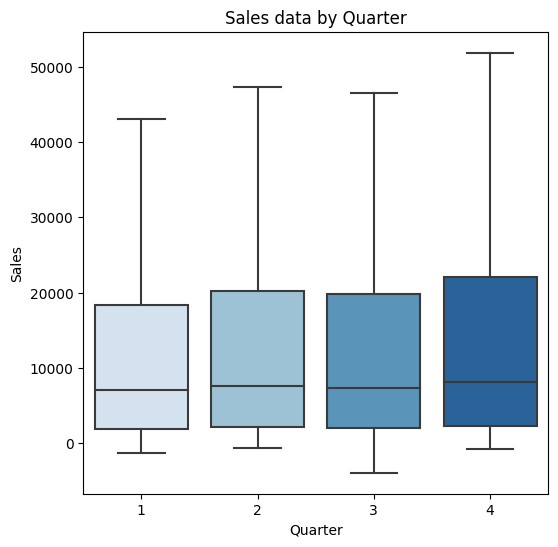

In [66]:
plt.figure(figsize=(6,6))
sns.boxplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')], x='Quarter', y='Weekly_Sales', 
            palette='Blues', showfliers=False
           ).set_title('Sales data by Quarter')
plt.ylabel('Sales')
plt.show()

**Q4 has the highest sales due to holiday season**

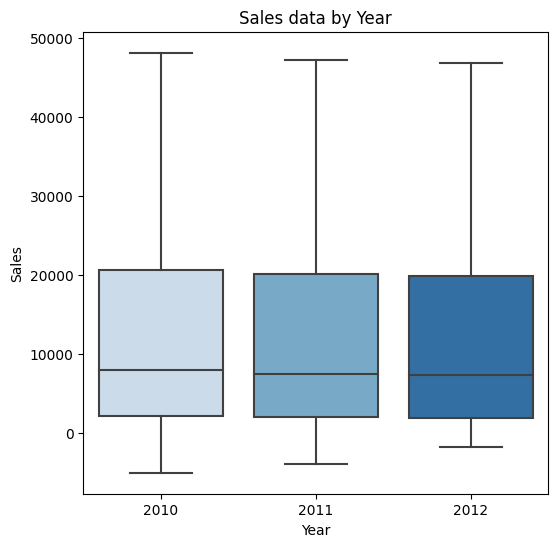

In [92]:
plt.figure(figsize=(6,6))
sns.boxplot(data=pdf, x='Year', y='Weekly_Sales', 
            palette='Blues', showfliers=False
           ).set_title('Sales data by Year')
plt.ylabel('Sales')
plt.show()

**We see a decrease in Sales from 2010 to 2012, It can happen due to the following reasons:**  
- We dont have sales of Nov and Dec in 2012  
- We also dont have sales of Jan in 2010 (which might make the avg a little higher than 2011)  

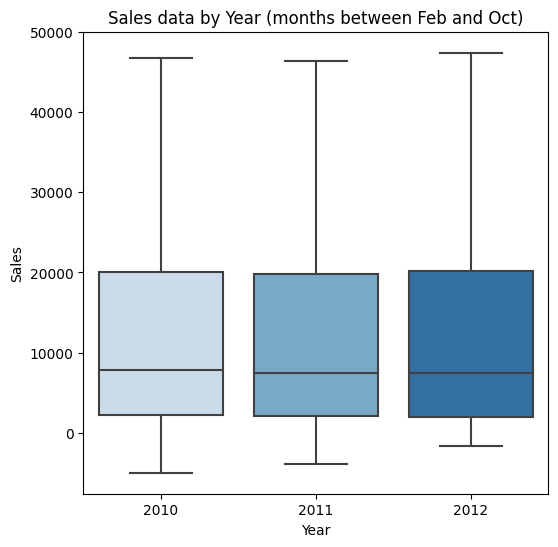

In [93]:
plt.figure(figsize=(6,6))
sns.boxplot(data=pdf.loc[pdf.index.month.isin([2,3,4,5,6,7,8,9,10])], x='Year', y='Weekly_Sales', 
            palette='Blues', showfliers=False
           ).set_title('Sales data by Year (months between Feb and Oct)')
plt.ylabel('Sales')
plt.show()


**Taking data of Months Feb-Oct as they are available for all years**  
- We can see the sales is not decreasing over the years

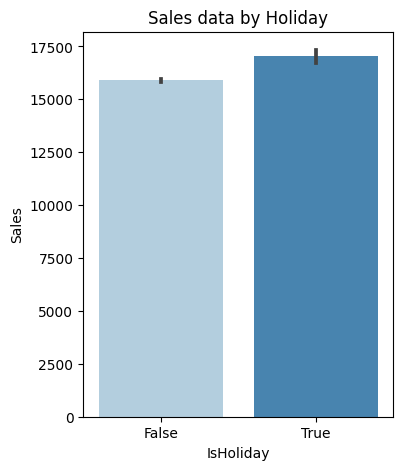

In [100]:
plt.figure(figsize=(4,5))
sns.barplot(data=pdf, x='IsHoliday', y='Weekly_Sales', 
            palette='Blues', #showfliers=False
           ).set_title('Sales data by Holiday')
plt.ylabel('Sales')
plt.show()

**Sales are slightly higher during Holidays**

## Analyzing Store Types with Sales

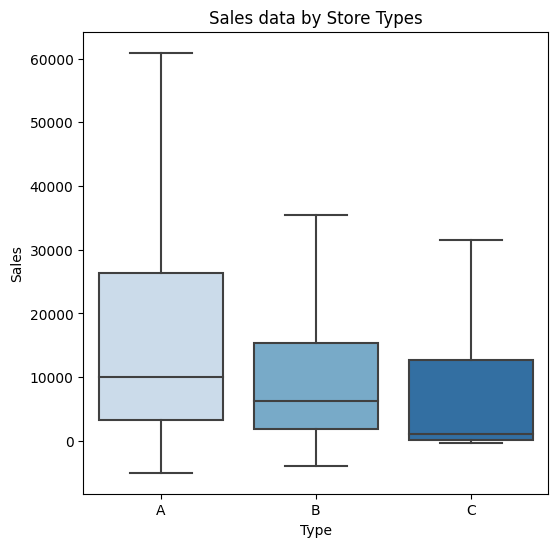

In [99]:
plt.figure(figsize=(6,6))
sns.boxplot(data=pdf, x='Type', y='Weekly_Sales', 
            palette='Blues' , showfliers=False
           ).set_title('Sales data by Store Types')
plt.ylabel('Sales')
plt.show()

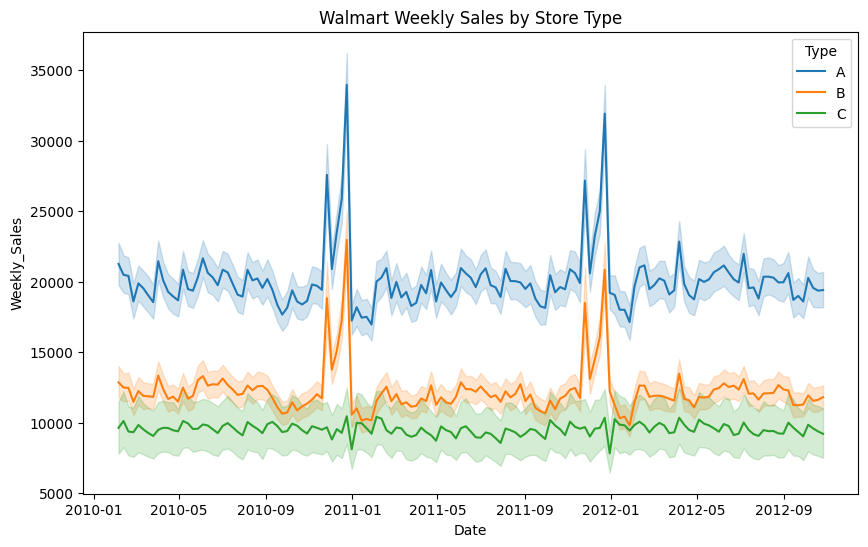

In [106]:
plt.figure(figsize=(10,6))
sns.lineplot(data=pdf, 
             x='Date', 
             y='Weekly_Sales',
             hue='Type'
            ).set_title('Walmart Weekly Sales by Store Type')
plt.show()

**Bigger stores (A) have higher sales compared to smaller stores (B)**

## Analyzing additional Features with Sales

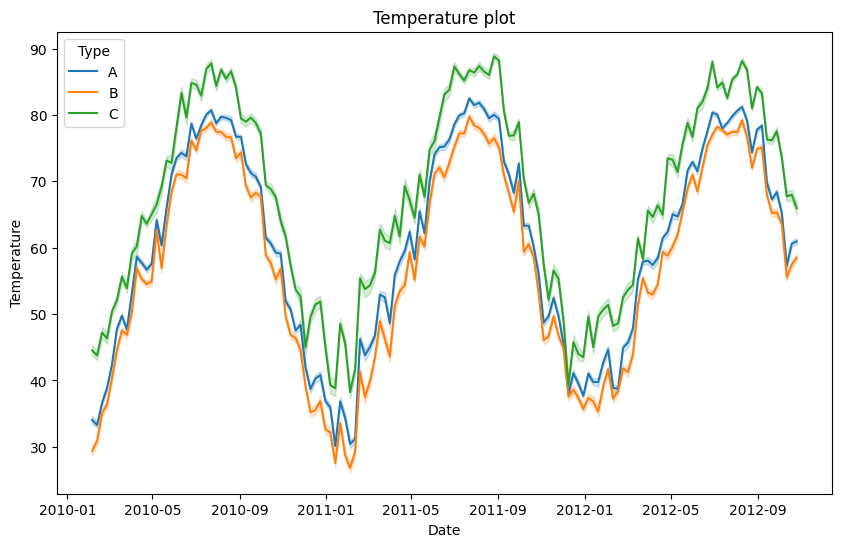

In [32]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=pdf, 
             x='Date', 
             y='Temperature',
             hue='Type',
             ax=ax,
            ).set_title('Temperature plot')
plt.show()

- Temperature around Type C stores (small stores) is high compared to other stores

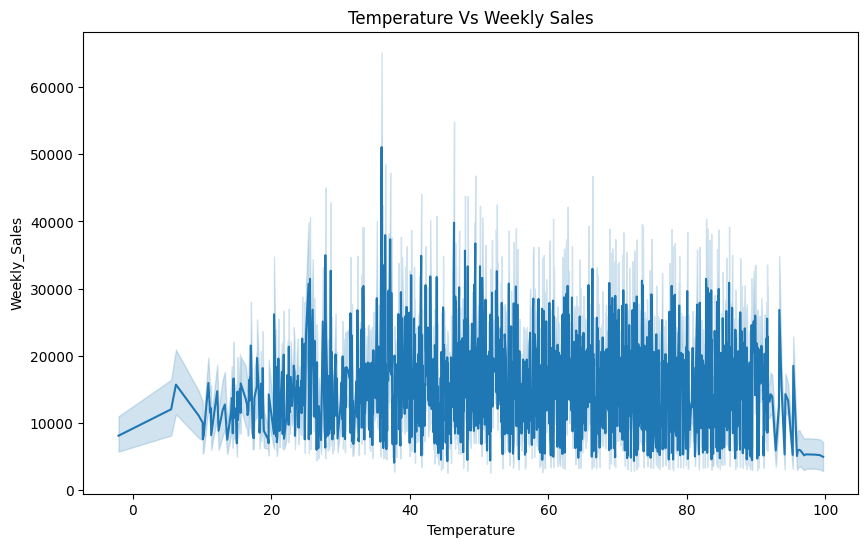

In [36]:
plt.figure(figsize=(10,6))
sns.lineplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')], 
             x='Temperature', 
             y='Weekly_Sales',
            ).set_title('Temperature Vs Weekly Sales')
plt.show()

**There is no effect of Temperature on Sales**

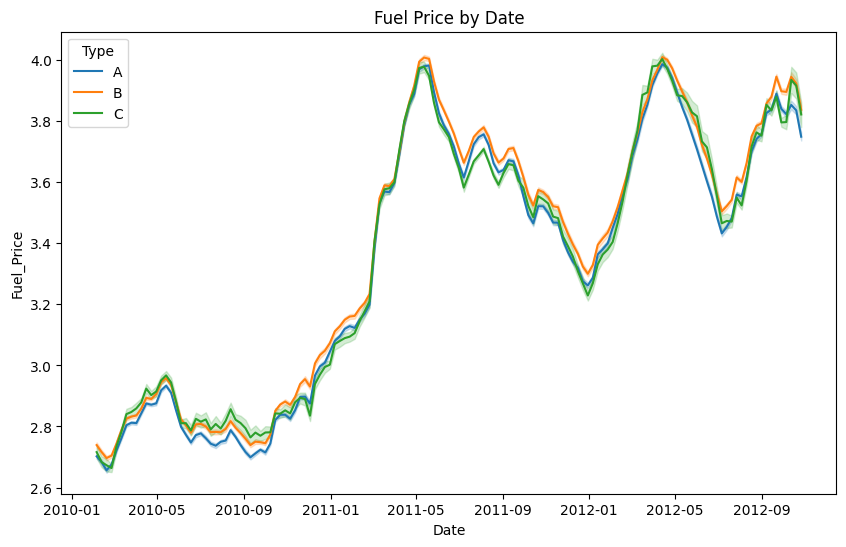

In [33]:
plt.figure(figsize=(10,6))
sns.lineplot(data=pdf, 
             x='Date', 
             y='Fuel_Price',
             hue='Type',
            ).set_title('Fuel Price by Date')
plt.show()

**Fuel price is identical for all store types**

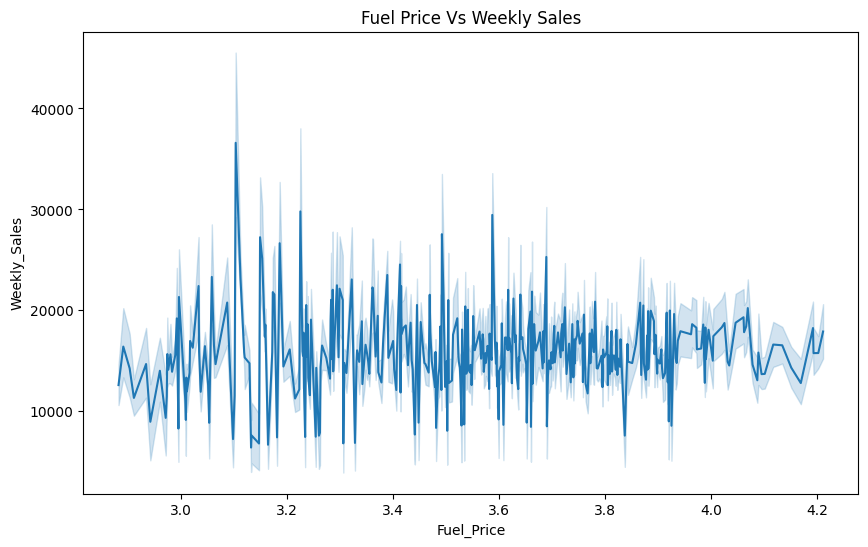

In [25]:
plt.figure(figsize=(10,6))
sns.lineplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')], 
             x='Fuel_Price', 
             y='Weekly_Sales',
            ).set_title('Fuel Price Vs Weekly Sales')
plt.show()

**There is no effect of Fuel Price of the region on Sales**

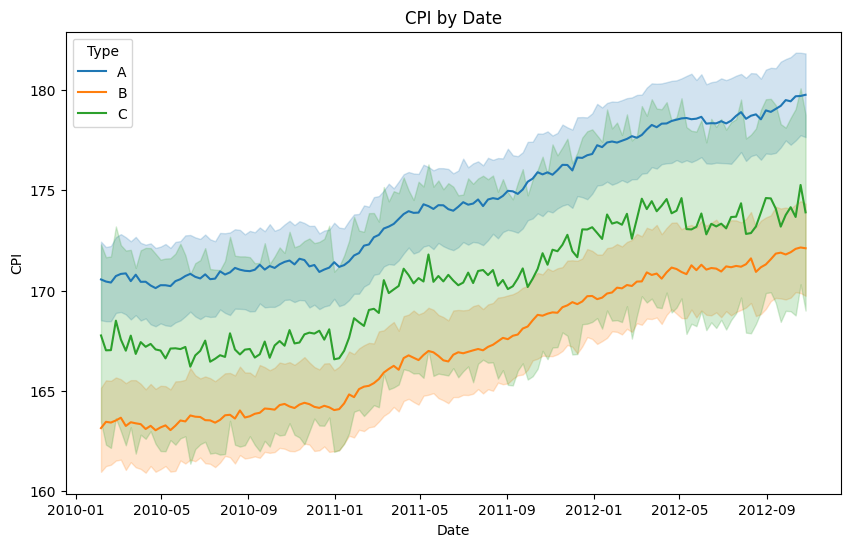

In [38]:
plt.figure(figsize=(10,6))
sns.lineplot(data=pdf, 
             x='Date', 
             y='CPI',
             hue='Type'
            ).set_title('CPI by Date')
plt.show()

- Overall CPI (Consumer Price Index) is increase over time  
- Type A stores have highest CPI index  
- Type C stores have higher CPI index than Type B stores  

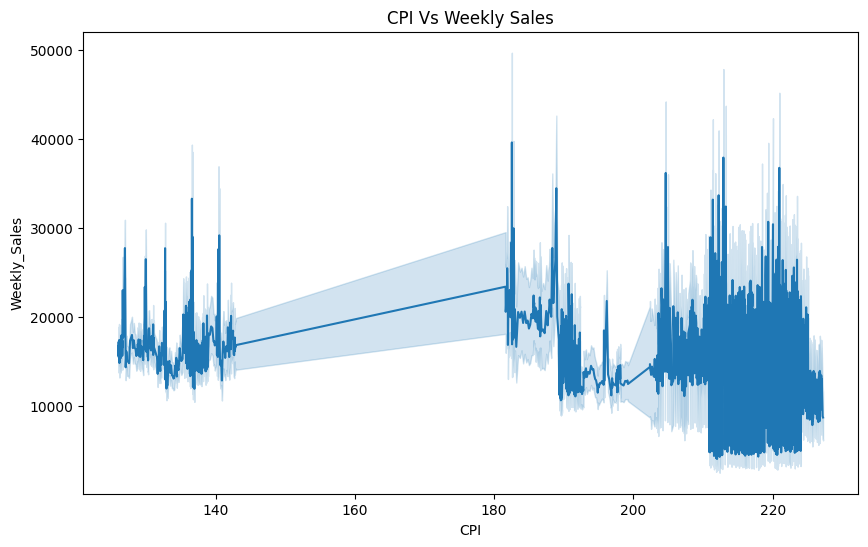

In [27]:
plt.figure(figsize=(10,6))
sns.lineplot(data=pdf, 
             x='CPI', 
             y='Weekly_Sales',
            ).set_title('CPI Vs Weekly Sales')
plt.show()

**There is no effect of CPI (Consumer Price Index) on sales**

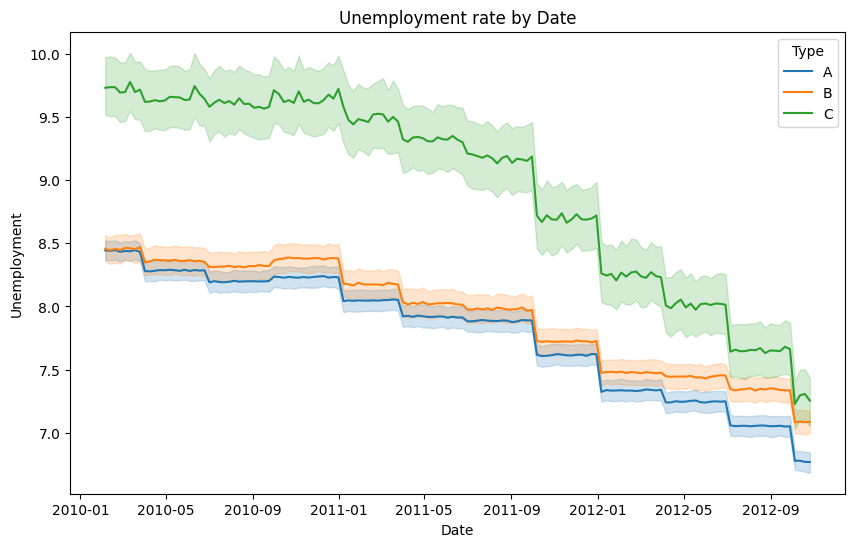

In [39]:
plt.figure(figsize=(10,6))
sns.lineplot(data=pdf, 
             x='Date', 
             y='Unemployment',
             hue='Type',
            ).set_title('Unemployment rate by Date')
plt.show()

- Unemployment Rate is descending over time
- Unemployment Rate is highest around Type C stores (small stores), they could be around rural areas
- Unemployment is similar around Type A and B stores

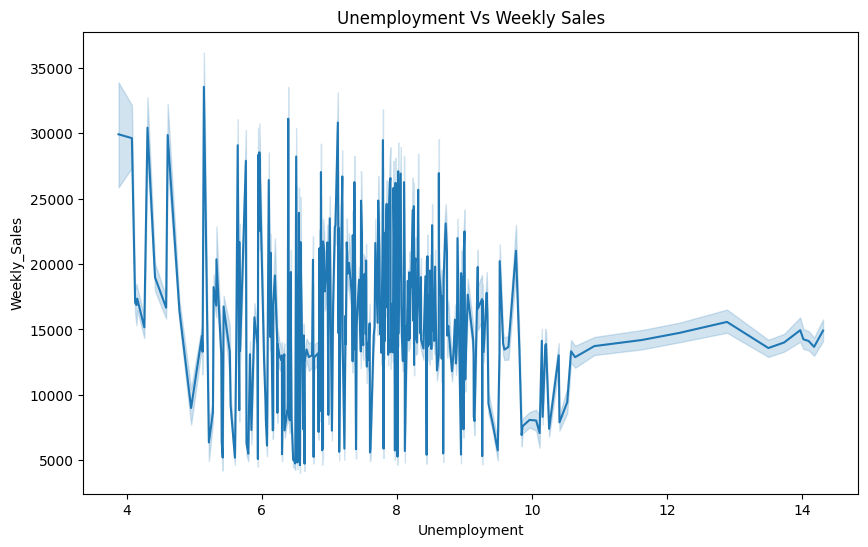

In [29]:
plt.figure(figsize=(10,6))
sns.lineplot(data=fpdf, 
             x='Unemployment', 
             y='Weekly_Sales',
            ).set_title('Unemployment Vs Weekly Sales')
plt.show()

**There is no effect of Unemployment on sales**

## Correlation Matrix

<Axes: >

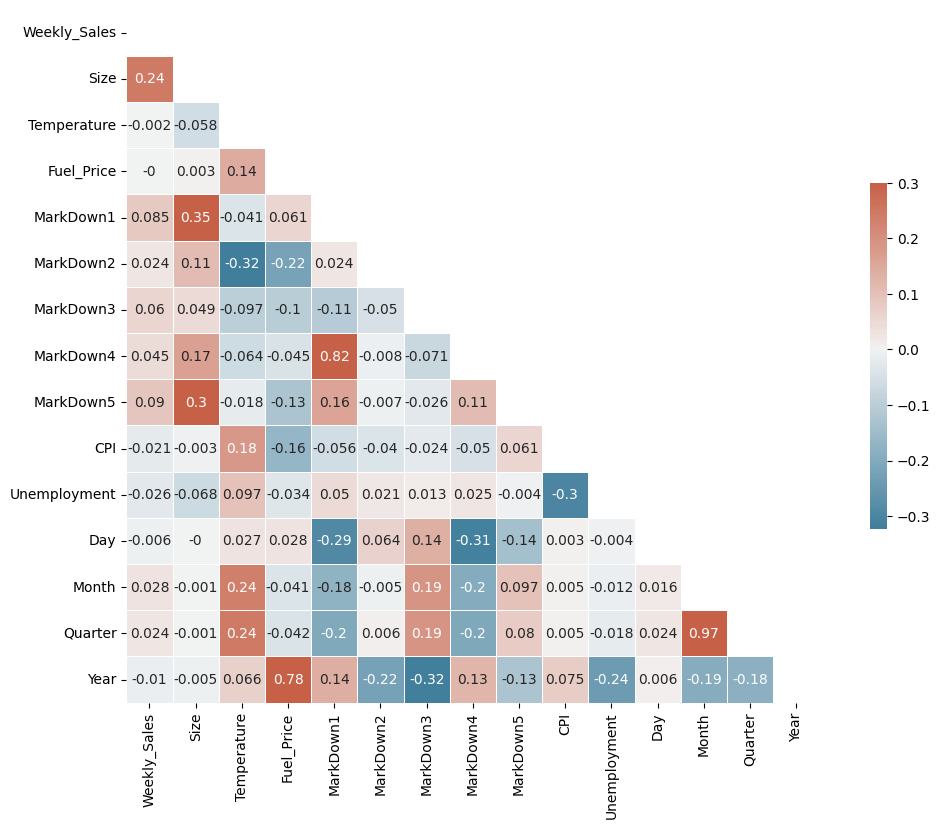

In [23]:
# Numerical cols
num_cols = [x for x in pdf.columns if x not in ['Type','IsHoliday','Dept','Store']]

# Compute the correlation matrix
corr = pdf[num_cols].corr().round(3)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

- MarkDown4 and MarkDown1 have high correlation  
- MarkDown1 and MarkDown5 have positive correlation with Size  
    - They could be exclusive offers for bigger stores  
- MarkDown2 have negative correlation with Temperature  
    - MarkDown2 could be offers during winters / holiday offers  

## AD Fuller Test

In [69]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(pdf.Weekly_Sales)   
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -31.988781724011776
p-value: 0.0


As the p-value is less than 0.05 and ADF statistic is a large negative number  
**The Time series is Stationary**

## Plotting ACF and PACF

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

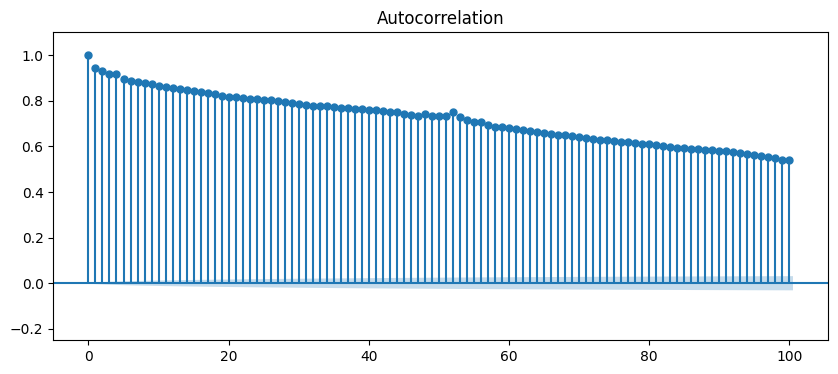

In [21]:
fig, ax = plt.subplots(figsize=(10,4))
acf_plot = plot_acf(pdf.Weekly_Sales, lags=100, ax=ax)
plt.ylim(-0.25, 1.1)
plt.show()

**Based on Decaying ACF, it is likely that we are dealing with an Auto Regressive process**  

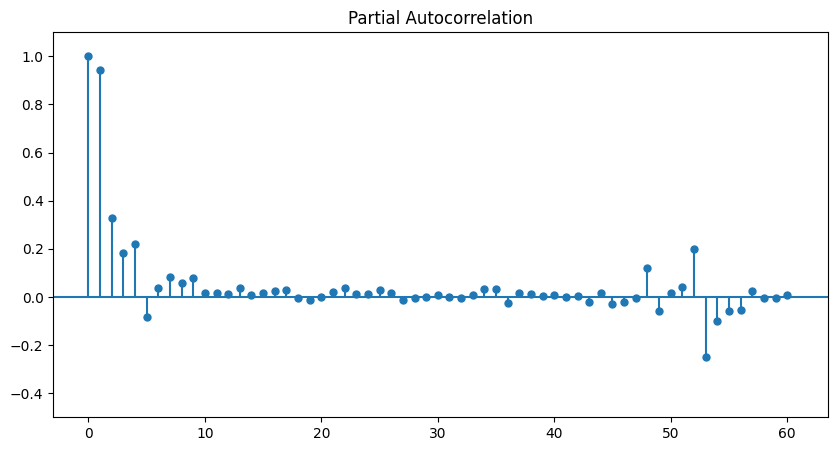

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
pacf_plot = plot_pacf(pdf.Weekly_Sales, lags=60, ax=ax)
plt.ylim(-0.5, 1.1)
plt.show()

**Based on PACF, we should start with Auto Regressive(AR) model with lags 1,2,4,51,52**